<a href="https://colab.research.google.com/github/j-buss/wi-dpi-analysis/blob/development/blog/5_A_Geographic_Descriptive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Teacher Salary in Wisconsin - 5A - Blog - Geographic Pay Analysis

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from google.cloud import bigquery
import matplotlib

In [0]:
%matplotlib inline
plt.style.use('bmh')

In [3]:
import matplotlib.style as style
style.available

['grayscale',
 'fivethirtyeight',
 'seaborn-notebook',
 'classic',
 'seaborn',
 '_classic_test',
 'bmh',
 'seaborn-dark-palette',
 'seaborn-colorblind',
 'seaborn-whitegrid',
 'seaborn-white',
 'seaborn-dark',
 'seaborn-poster',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'seaborn-bright',
 'seaborn-muted',
 'seaborn-talk',
 'dark_background',
 'tableau-colorblind10',
 'seaborn-deep',
 'ggplot',
 'fast',
 'seaborn-pastel',
 'Solarize_Light2',
 'seaborn-paper']

In [0]:
style.use('fivethirtyeight')

### Functions

In [0]:
# To help with the pie charts later
def make_autopct(values):
  def my_autopct(pct):
    total = sum(values)
    val = int(round(pct*total/100.0))
    return '{p:.2f}% \n({v:,d})'.format(p=pct,v=val)
  return my_autopct

### Processing

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
project_id='wi-dpi-010'
landing_dataset_name='landing'
refined_dataset_name='refined'
gold_dataset_name='gold'

In [0]:
bq_client = bigquery.Client(project=project_id)

### Cesa Summary

Let's add another layer to the analysis. We can look at differences by location. A number of initial questions come to mind very quickly.


1.   What is area with the highest average salary? What about the lowest?
2.   What is the area with the highest starting salary? What about the lowest?
3.   Are average salaries found in geographic groups?

Well, to start answering these questions let's bring to mind the geographic hiearchy...or rather how do we start at the top: State and work our way down to School District...or maybe even school.

Fortunately for us this topic is a fairly common one and the WI Department of Public Instruction has devised our first "layer" under a state. It is CESA.

And as any group of people we must refer to the acronyms! CESA is the "Cooperative Educational Service Agency". For our purposes it simply groups districts together. However, for more information you can consult the [WI DPI CESA](https://dpi.wi.gov/cesa) page.



Within the information we have already looked at there is a code showing the CESA number for an individual role. 

Now there are a few individuals who do work "across" CESA districts. However for this analysis we will set asside those individuals and stick with the vast majority (99.45%) of individuals who work in only one district. 

In [0]:
sql = '''
SELECT
  Cesa_Num,
  Round(Salary,2) as Salary,
  research_ID,
  Round(max_contract_total_experience,2) as experience,
  Round(age,2) as age,
  max_contract_days,
  assignment_fte
FROM
  {}.{}
WHERE
  Pos_Cat_Flag = 'T'
  '''.format('refined','2017_geo_Analysis_level_01')

In [10]:
geo_analysis_df = pd.read_gbq(sql, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [0]:
geo_analysis_df['contract_days_median'] = geo_analysis_df['max_contract_days'].median()
geo_analysis_df['contract_days_std'] = geo_analysis_df['max_contract_days'].std()

In [12]:
geo_analysis_df.head(5)

,Cesa_Num,Salary,research_ID,experience,age,max_contract_days,assignment_fte,contract_days_median,contract_days_std
0,1,4700.0,100910,7.0,19.0,191,0.1,190.0,11.942235
1,10,71000.0,95910,4.0,20.0,188,1.0,190.0,11.942235
2,1,4500.0,3999,0.5,21.0,93,0.5,190.0,11.942235
3,1,41311.0,160958,1.0,21.0,191,1.0,190.0,11.942235
4,7,4500.0,5845,1.0,21.0,92,0.5,190.0,11.942235


#### Average Salary by Cesa

In [0]:
green_cm = sns.light_palette("green", as_cmap=True)
blue_cm = sns.light_palette("blue", as_cmap=True)

In [0]:
Cesa_Sum_All_df = geo_analysis_df.groupby('Cesa_Num') \
  .agg({'Salary':'mean', 'research_ID':'size', 'experience':'mean', 'age':'mean'}) \
  .reset_index() \
  .rename(columns={'Salary':'Avg. Sal.', 'research_ID':'Indv. Count',\
                   'experience':'Avg. Exp.','age':'Avg. Age',\
                   'Cesa_Num':'CESA Num.'})

In [63]:
Cesa_Sum_All_format_dict = {'Avg. Sal.':'${0:,.0f}','Indv. Count':'{0:,}',\
                            'Avg. Exp.':'{0:,.1f}','Avg. Age':'{0:,.1f}',\
                           'CESA Num.':'{0:,}'}

Cesa_Sum_All_df.style.format(Cesa_Sum_All_format_dict).hide_index()\
  .set_properties( **{'width':'100px','text-align':'center',\
                      'color': 'black',\
                      'border-collapse': 'collapse'})#\
  #.background_gradient(subset=['Avg. Sal.'],cmap=green_cm)\
  #.background_gradient(subset=['Avg. Age'],cmap=blue_cm)

CESA Num.,Avg. Sal.,Indv. Count,Avg. Exp.,Avg. Age,CESA String
1,"$59,308","16,863",14.0,42.0,1
2,"$54,058","11,907",13.7,41.2,2
3,"$50,063","1,647",15.7,42.3,3
4,"$50,334","2,913",14.2,41.1,4
5,"$52,060","3,901",14.8,41.9,5
6,"$54,423","7,144",14.6,41.2,6
7,"$54,412","6,388",14.6,41.6,7
8,"$49,267","1,612",14.7,42.6,8
9,"$54,666","2,564",14.7,42.0,9
10,"$50,481","2,727",14.3,41.1,10


In [0]:
annotation_offset_salary = 75
annotation_offset_exp = 0.025

In [0]:
Cesa_Sum_All_df['CESA String'] = Cesa_Sum_All_df['CESA Num.'].astype(str)

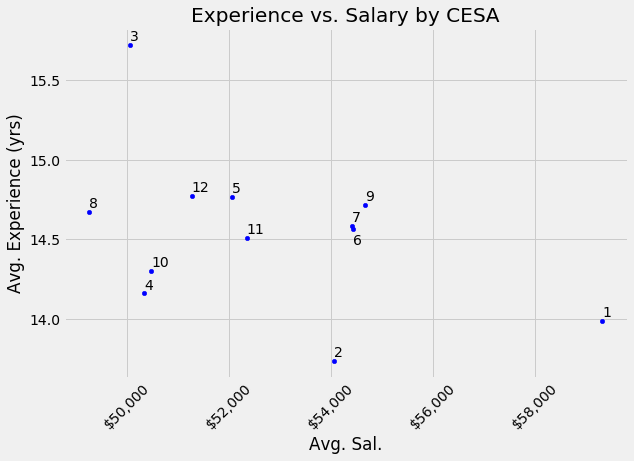

In [31]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1,
                           figsize=(9,6))

currency_fmt = '${x:,.0f}'
currency_tick = mtick.StrMethodFormatter(currency_fmt)

ax = Cesa_Sum_All_df.plot.scatter(x="Avg. Sal.", y="Avg. Exp.", ax=ax1, color='b')
ax1.set_ylabel('Avg. Experience (yrs)')
ax1.xaxis.set_major_formatter(currency_tick) 
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_locator(mtick.MultipleLocator(0.5))
ax1.set_title('Experience vs. Salary by CESA')

for k, v in Cesa_Sum_All_df.iterrows():
    if v['CESA String'] == '6':
      annotation_offset_exp = -0.1 
    else:
      annotation_offset_exp = 0.025
    ax.text(v['Avg. Sal.'], v['Avg. Exp.']+annotation_offset_exp, v['CESA String'])

#### Average Starting Salary by Cesa

In [0]:
geo_analysis_firstyear_df = geo_analysis_df[
    (geo_analysis_df['experience']<= 1.0) & \
    (geo_analysis_df['assignment_fte']>=1.0) & \
    (geo_analysis_df['max_contract_days'] >= geo_analysis_df['contract_days_median']-2*geo_analysis_df['contract_days_std']) \
]

In [0]:
Cesa_Sum_FirstYear_df = geo_analysis_firstyear_df.groupby('Cesa_Num') \
  .agg({'Salary':'mean', 'research_ID':'size', 'experience':'mean', 'age':'mean'}) \
  .reset_index() \
  .rename(columns={'Salary':'Avg. Sal. (1st Yr.)', 'research_ID':'Indv. Count (1st Yr.)',\
                   'Cesa_Num':'CESA Num.'})

In [60]:
Cesa_Sum_FirstYear_format_dict = {'Avg. Sal. (1st Yr.)':'${0:,.0f}','Indv. Count (1st Yr.)':'{0:,}',\
                            'Avg. Exp.':'{0:,.1f}','Avg. Age':'{0:,.1f}',\
                           'CESA Num.':'{0:,}'}


Cesa_Sum_FirstYear_df[['Avg. Sal. (1st Yr.)','CESA Num.']].style.format(Cesa_Sum_FirstYear_format_dict).hide_index()\
  .set_properties( **{'width':'150px','text-align':'center',\
                      'color': 'black',\
                      'border-collapse': 'collapse'})\
  .background_gradient(subset=['Avg. Sal. (1st Yr.)'],cmap=green_cm)

Avg. Sal. (1st Yr.),CESA Num.
"$46,158",1
"$43,212",2
"$38,936",3
"$38,303",4
"$40,278",5
"$41,804",6
"$41,643",7
"$38,079",8
"$41,858",9
"$39,104",10


In [0]:
Cesa_Sum_FirstYear_df['CESA String'] = Cesa_Sum_FirstYear_df['CESA Num.'].astype(str)

In [98]:
Cesa_Sum_FirstYear_df[Cesa_Sum_FirstYear_df.columns[1:]]

,Avg. Sal. (1st Yr.),Indv. Count (1st Yr.),experience,age
0,46157.836611,661,0.989410,30.373676
1,43211.625229,547,0.971664,30.120658
2,38936.373494,83,0.981928,27.771084
3,38302.849206,126,1.000000,27.158730
4,40277.655556,180,0.963889,29.211111
5,41804.308300,253,1.000000,29.418972
6,41642.736000,250,0.992000,29.704000
7,38078.833333,66,1.000000,31.060606
8,41857.508621,116,0.956897,29.879310
9,39103.684211,95,0.989474,27.421053


In [0]:
# Add to the other Dataframe
result = pd.concat([Cesa_Sum_All_df, Cesa_Sum_FirstYear_df[Cesa_Sum_FirstYear_df.columns[1:]]], axis=1, sort=False)

In [100]:
result

,CESA Num.,Avg. Sal.,Indv. Count,Avg. Exp.,Avg. Age,CESA String,Avg. Sal. (1st Yr.),Indv. Count (1st Yr.),experience,age
0,1,59307.509874,16863,13.989000,42.003202,1,46157.836611,661,0.989410,30.373676
1,2,54057.697489,11907,13.736877,41.160998,2,43211.625229,547,0.971664,30.120658
2,3,50062.897389,1647,15.723437,42.290225,3,38936.373494,83,0.981928,27.771084
3,4,50333.724339,2913,14.161002,41.088912,4,38302.849206,126,1.000000,27.158730
4,5,52059.911561,3901,14.766342,41.917457,5,40277.655556,180,0.963889,29.211111
5,6,54423.389558,7144,14.564740,41.159994,6,41804.308300,253,1.000000,29.418972
6,7,54412.092048,6388,14.584220,41.642611,7,41642.736000,250,0.992000,29.704000
7,8,49266.822581,1612,14.673077,42.605459,8,38078.833333,66,1.000000,31.060606
8,9,54665.723869,2564,14.717044,42.047972,9,41857.508621,116,0.956897,29.879310
9,10,50481.013568,2727,14.300880,41.079208,10,39103.684211,95,0.989474,27.421053


In [0]:
Cesa_Sum_df = result[['CESA Num.','Avg. Sal.', 'Indv. Count', 'Avg. Sal. (1st Yr.)', 'Indv. Count (1st Yr.)']]

In [0]:
test = Cesa_Sum_df[Cesa_Sum_df.columns[1:]].copy()

In [95]:
test

,CESA Num.,CESA Num.,Avg. Sal.,Indv. Count,Avg. Sal. (1st Yr.),Indv. Count (1st Yr.)
0,1,1,59307.509874,16863,46157.836611,661
1,2,2,54057.697489,11907,43211.625229,547
2,3,3,50062.897389,1647,38936.373494,83
3,4,4,50333.724339,2913,38302.849206,126
4,5,5,52059.911561,3901,40277.655556,180
5,6,6,54423.389558,7144,41804.308300,253
6,7,7,54412.092048,6388,41642.736000,250
7,8,8,49266.822581,1612,38078.833333,66
8,9,9,54665.723869,2564,41857.508621,116
9,10,10,50481.013568,2727,39103.684211,95


In [103]:
Cesa_Sum_format_dict = {'Avg. Sal. (1st Yr.)':'${0:,.0f}','Indv. Count (1st Yr.)':'{0:,}',\
                            'Avg. Sal.':'${0:,.0f}','Indv. Count':'{0:,}',\
                           }

# Show the Dataframe again
Cesa_Sum_df.style.format(Cesa_Sum_format_dict).hide_index()\
  .set_properties( **{'width':'135px','text-align':'center',\
                      'color': 'black',\
                      'border-collapse': 'collapse'})\
  .background_gradient(subset=['Avg. Sal.'],cmap=green_cm)\
  .background_gradient(subset=['Avg. Sal. (1st Yr.)'],cmap=blue_cm)

CESA Num.,Avg. Sal.,Indv. Count,Avg. Sal. (1st Yr.),Indv. Count (1st Yr.)
1,"$59,308","16,863","$46,158",661
2,"$54,058","11,907","$43,212",547
3,"$50,063","1,647","$38,936",83
4,"$50,334","2,913","$38,303",126
5,"$52,060","3,901","$40,278",180
6,"$54,423","7,144","$41,804",253
7,"$54,412","6,388","$41,643",250
8,"$49,267","1,612","$38,079",66
9,"$54,666","2,564","$41,858",116
10,"$50,481","2,727","$39,104",95


Need to load the districts / CESA information https://apps4.dpi.wi.gov/SchoolDirectory/Search/PublicDistrictsSearch

### District Summary

So the analysis by CESA is useful, but still just a first step. It is a fairly high level construct and not something than any of us talk about. 

Let's add another dimension here and look at the information by district. This is a much more useful grouping of the teacher data as it is something that people fundamentally understand.

The School Districts are the geographic areas that we discuss in our day to day life. Children that live in our neighborhoods attend schools in districts, when we go and vote there is a question about how we would like to spend money for our district.

In a similar fashion to the way we started the analysis for CESA there are a few individuals who do work "across" School Districts. So we will set asside those individuals and stick with the vast majority (99.45%) of individuals who work in only one district.

### Map Salary Ranges

So the previous analysis is good. However...yeah it is a bit lacking. I mean it feels like we need to bring the whole visual aspect into the analysis. I mean there is lots of good data in a list with averages, but let's add the whole mapping piece.

If we want to add the map components we can consult the Open GEO Data for Wisconsin: http://geodata.wisc.edu/opengeoportal/
The site has a nice interface in which to search for specific geographic information systems (GIS) data.

#### By Cesa

### District Summary

#### Average Salary by District

In [0]:
# Ascending - Top 10

In [0]:
# Descending - Top 10

Let's just map the CESA Areas...

In [0]:
# CODE FOR MAP

Ok. Getting there. Now let's bring in the color coding based on the average salary.

In [0]:
# Color based on Average Salary

In [0]:
# Color based on 1st year Salary

#### By District

In [0]:
# Color based on Average Salary

In [0]:
# Color based on 1st year Salary